In [2]:
data_directory = "C:\\Users\\rites\\Downloads\\speech-emotion-recognition-ravdess-data"

In [3]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import np_utils
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics

In [4]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

In [5]:
def extract_feature(data, sr, mfcc, chroma, mel):
    
    """
    extract features from audio files into numpy array
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency
    
    """
    
    if chroma:                          
        stft = np.abs(librosa.stft(data))  
    result = np.array([])
    if mfcc:                          
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:                          
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:                             
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))
        
    return result 

In [6]:
def noise(data, noise_factor):
    
    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added 

    """
    noise = np.random.randn(len(data)) 
    augmented_data = data + noise_factor * noise
    
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [7]:
def shift(data, sampling_rate, shift_max, shift_direction):
    
    """
    shift the spectogram in a direction
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both
    
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
        
    return augmented_data

In [8]:
def load_data(save=False):
    
    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy

    """
    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.    
        data, sr = librosa.load(file)
        
        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)
        
        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]  
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)
    
    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)
        
    return np.array(x), y

In [9]:
X, y = load_data(save=True)

# X = np.load("X.npy")
# y = np.load("y.npy")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

In [10]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [11]:

# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [12]:
# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(units=8,
#                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
#                 bias_regularizer=regularizers.l2(1e-4),
#                 activity_regularizer=regularizers.l2(1e-5)
#                 )
# ) # 7th layer
# model.add(Activation('softmax'))
# opt = keras.optimizers.adam(decay=1e-6)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf

# Define the model architecture
model = Sequential()
model.add(Conv1D(256, 5, padding='same', input_shape=(180, 1)))  # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))  # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))  # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))  # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                ))  # 7th layer
model.add(Activation('softmax'))

# Define the learning rate schedule with decay
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)
opt = Adam(learning_rate=lr_schedule)

# # Compile the model
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()



In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [14]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/100
51/51 [==============================] - 16s 213ms/step - loss: 2.2670 - accuracy: 0.2148 - val_loss: 1.9003 - val_accuracy: 0.3593
Epoch 2/100
51/51 [==============================] - 9s 186ms/step - loss: 1.9308 - accuracy: 0.3111 - val_loss: 1.8235 - val_accuracy: 0.3796
Epoch 3/100
51/51 [==============================] - 10s 191ms/step - loss: 1.8087 - accuracy: 0.3744 - val_loss: 1.6854 - val_accuracy: 0.4333
Epoch 4/100
51/51 [==============================] - 9s 177ms/step - loss: 1.6895 - accuracy: 0.4157 - val_loss: 1.5866 - val_accuracy: 0.4722
Epoch 5/100
51/51 [==============================] - 9s 181ms/step - loss: 1.6108 - accuracy: 0.4441 - val_loss: 1.5449 - val_accuracy: 0.4843
Epoch 6/100
51/51 [==============================] - 9s 183ms/step - loss: 1.5171 - accuracy: 0.4849 - val_loss: 1.4432 - val_accuracy: 0.5185
Epoch 7/100
51/51 [==============================] - 10s 206ms/step - loss: 1.4377 - accuracy: 0.5068 - val_loss: 1.3970 - val_accuracy: 0.5

51/51 [==============================] - 19s 375ms/step - loss: 0.2914 - accuracy: 0.9664 - val_loss: 0.6082 - val_accuracy: 0.8787
Epoch 58/100
51/51 [==============================] - 18s 343ms/step - loss: 0.2604 - accuracy: 0.9719 - val_loss: 0.6212 - val_accuracy: 0.8833
Epoch 59/100
51/51 [==============================] - 17s 331ms/step - loss: 0.2546 - accuracy: 0.9750 - val_loss: 0.6134 - val_accuracy: 0.8833
Epoch 60/100
51/51 [==============================] - 17s 342ms/step - loss: 0.2580 - accuracy: 0.9772 - val_loss: 0.6684 - val_accuracy: 0.8852
Epoch 61/100
51/51 [==============================] - 17s 334ms/step - loss: 0.2444 - accuracy: 0.9812 - val_loss: 0.6253 - val_accuracy: 0.8843
Epoch 62/100
51/51 [==============================] - 17s 324ms/step - loss: 0.2388 - accuracy: 0.9827 - val_loss: 0.6480 - val_accuracy: 0.8870
Epoch 63/100
51/51 [==============================] - 17s 334ms/step - loss: 0.2819 - accuracy: 0.9719 - val_loss: 0.7265 - val_accuracy: 0.863

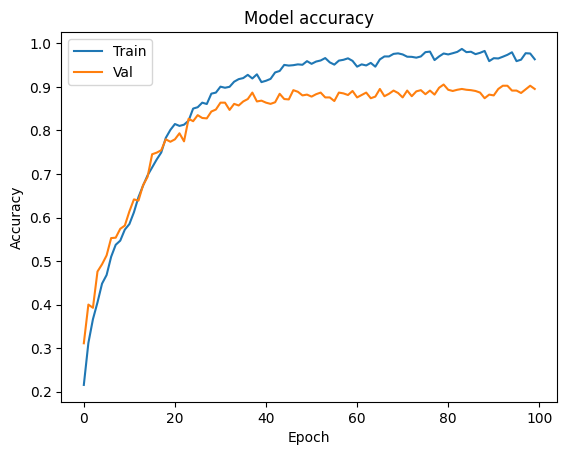

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

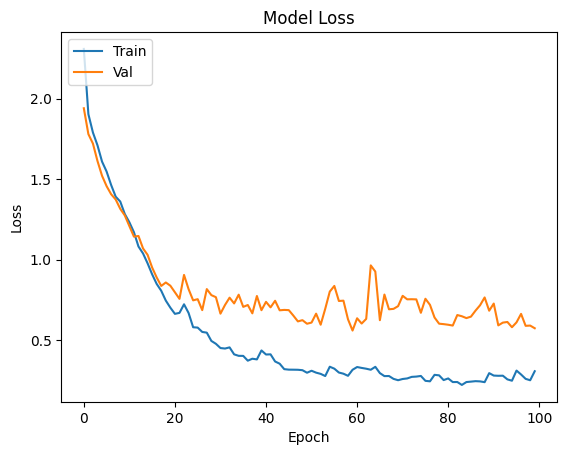

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [26]:
y_pred = model.predict(XTestProcessed)

34/34 [==============================] - 1s 15ms/step


<Axes: >

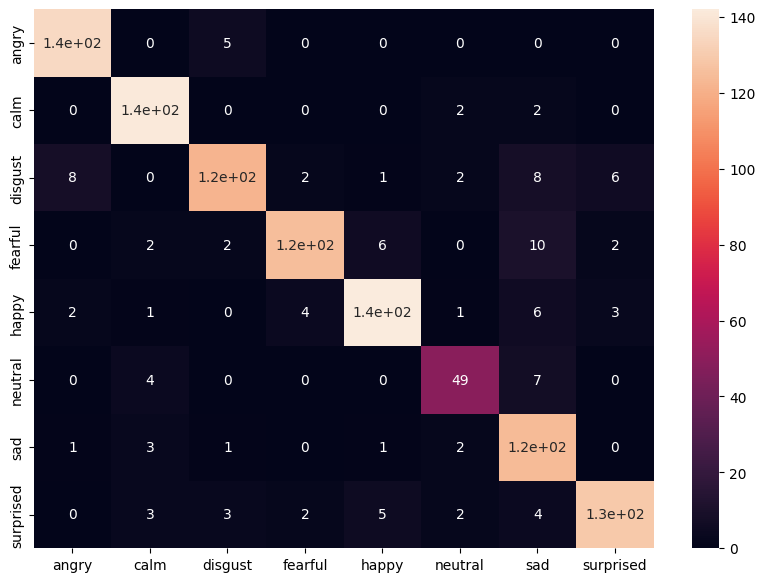

In [27]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

In [1]:
f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')

NameError: name 'f1_score' is not defined

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 180, 256)          1536      
                                                                 
 activation_15 (Activation)  (None, 180, 256)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 180, 128)          163968    
                                                                 
 activation_16 (Activation)  (None, 180, 128)          0         
                                                                 
 dropout_6 (Dropout)         (None, 180, 128)          0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 22, 128)           0         
 g1D)                                                            
                                                      

In [30]:
def load_single_data(file):
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

In [31]:
XX, yy = load_single_data("C:\\Users\\rites\\Downloads\\speech-emotion-recognition-ravdess-data/Actor_01/03-01-05-02-02-02-01.wav")

In [32]:
yy


['angry']